# Consistency Models

Consistency Models, Song et al., 2023. [[arXiv:2303.01469](https://arxiv.org/abs/2303.01469)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

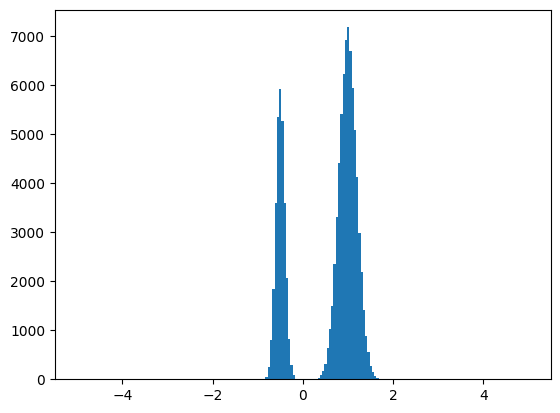

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Score Model

Define MLP backbone and score model first.

In [2]:
from flowmodels import VESDE, VESDEScheduler
from utils import Backbone

COND = True
aux = 1 if not COND else 2
model = VESDE(Backbone(aux=aux), VESDEScheduler())
model

VESDE(
  (score_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Score Model

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

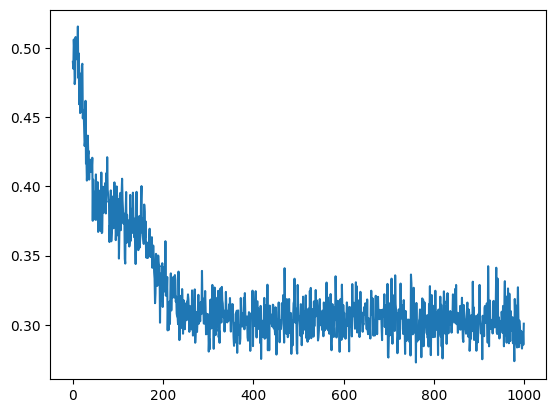

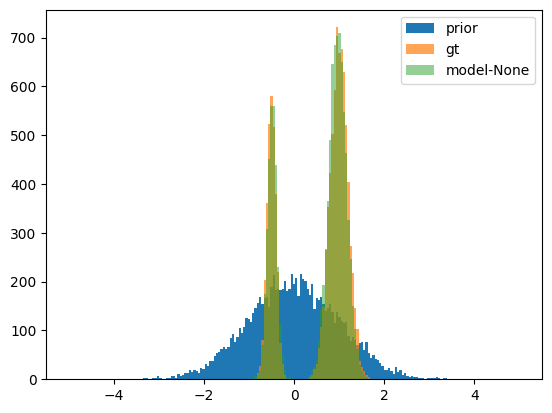

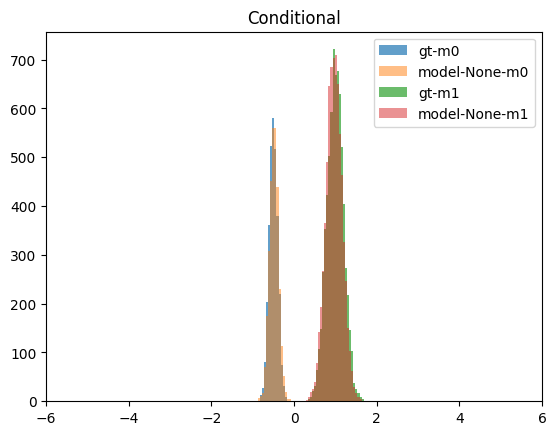

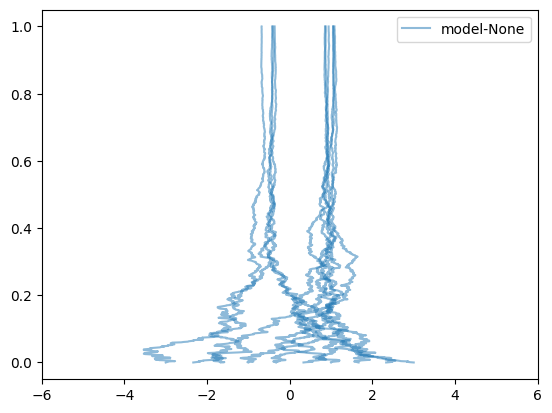

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[None])

## 4. Consistency Distillation

Distill the knowledge of the pretrained score model to Consistency Models

  0%|          | 0/1000 [00:00<?, ?it/s]

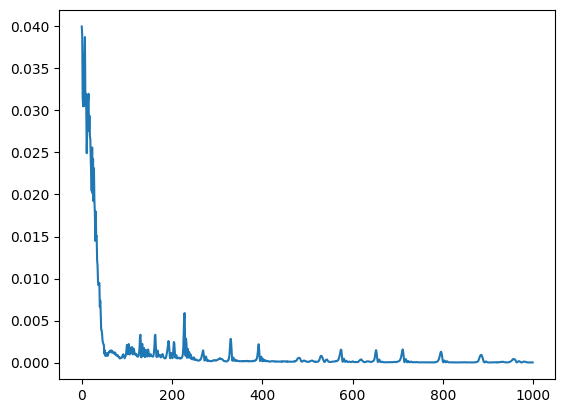

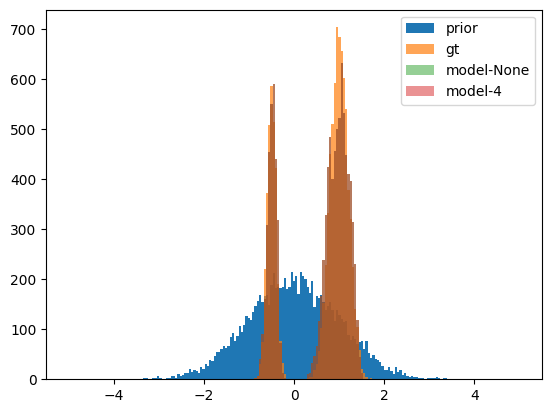

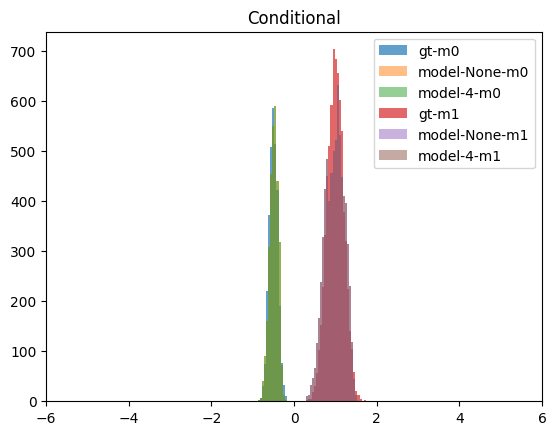

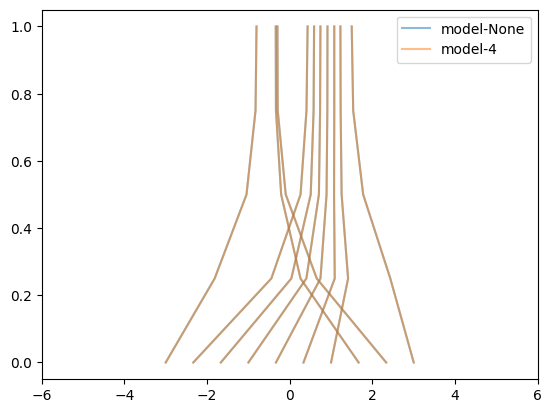

In [4]:
from flowmodels import ConsistencyModel, ConsistencyModelScheduler

# define rectified diffusion
_var_max = model.scheduler.var(torch.ones(1)).item()
cm = ConsistencyModel(
    Backbone(aux=aux), ConsistencyModelScheduler(T=16, var_max=_var_max)
)

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim = torch.optim.Adam(cm.parameters(), LR)
losses, ema = cm.distillation(
    model,
    optim,
    TRAIN_STEPS,
    BATCH_SIZE,
    X,
    mu=0.9,
    label=Y if COND else None,
    verbose=lambda r: tqdm(r, leave=False),
)
plt.plot(losses)
vis(cm, conditional=COND, steps=[None, 4])